## Detectron2 Training

**Set the following variables, and run all.**

The notebook reports COCO eval metrics and visualizations at the end.

`img_dir`: location of all images (both training and test)

`train_json`: COCO annotation file consisting of training set annotations 

`test_json`: COCO annotation file consisting of test / validation set annotations

`dataset_name`: a name for the dataset, for detectron2 bookkeeping

In [1]:
coco_yaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
lvis_yaml = "LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
lvis_yaml2 = "LVIS-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml"
pano_yaml = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"

img_dir_test = '/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb'
img_dir_train = '/checkpoint/apratik/finals/straightline/apartment_0/rgb'
# img_dir_test = '/checkpoint/apratik/finals/default/apartment_0/rgb'


# img_dir = '/home/locobotm/AVD/habitat_data_with_seg/rgb/'
# train_json = '/home/locobotm/AVD/habitat_data_with_seg/train.json'

# sanity checking 
# train_jsons = [
#     'active_vision/sanity_default_apt0_1n.json',
#     'active_vision/sanity_default_apt0_10n.json',
#     'active_vision/sanity_default_apt0_20n.json',
#     'active_vision/sanity_default_apt0_30n.json',
#     'active_vision/sanity_default_apt0_40n.json',
#     'active_vision/sanity_default_apt0_50n.json',
#     'active_vision/sanity_default_apt0_60n.json',
#     'active_vision/sanity_default_apt0_70n.json',
#     'active_vision/sanity_default_apt0_80n.json',
# ]

# Table 2 - prop fixed, label prop, different GT frames, default heu
# train_jsons = [
#     'active_vision/default_apt0_gt50p2fix_corln.json',
#     'active_vision/default_apt0_gt100p2fix_corln.json',
#     'active_vision/default_apt0_gt150p2fix_corln.json',
#     'active_vision/default_apt0_gt200p2fix_corln.json',
#     'active_vision/default_apt0_gt250p2fix_corln.json',
# ]

# Table 2 - prop fixed, no label prop, different GT frames
# train_jsons = [
#     'active_vision/base_straightline_apt0_gt50p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt100p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt150p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt200p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt250p2fix_corln.json',
# ]

# Table 2 - prop fixed, label prop, different GT frames
# train_jsons = [
#     'active_vision/straightline_apt0_gt50p2fix_corln.json',
#     'active_vision/straightline_apt0_gt100p2fix_corln.json',
#     'active_vision/straightline_apt0_gt150p2fix_corln.json',
#     'active_vision/straightline_apt0_gt200p2fix_corln.json',
#     'active_vision/straightline_apt0_gt250p2fix_corln.json',
# ]

# Table 1 - gt fixed, different label prop lengths
train_jsons = [
    'active_vision/straightline_apt0_gt100p1_corln.json',
    'active_vision/straightline_apt0_gt100p2_corln.json',
    'active_vision/straightline_apt0_gt100p4_corln.json',
    'active_vision/straightline_apt0_gt100p6_corln.json',
]
    
# test_json = 'active_vision/sanity_default_apt0_segn.json' 
test_json = 'active_vision/frlapt1_10n.json'
dataset_name = 'habitat_1'

In [2]:
import torchvision

# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import random
import os
import numpy as np
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
    
import random
import torch 
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image

pd.set_option('max_colwidth', 300)

import glob
from IPython.core.display import display, HTML

pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))

os.environ['TENSORBOARD_BINARY'] = '/private/home/apratik/.conda/envs/locobot_env/bin/tensorboard'

## Detectron2 Setup

class COCOTrain:
    def reset(self, train_json, test_json, img_dir_train, img_dir_test):
        DatasetCatalog.clear()
        MetadataCatalog.clear()
        self.train_data = dataset_name +  "_train"
        self.val_data = dataset_name + "_val"
        self.train_json = train_json
        self.test_json = test_json
        register_coco_instances(self.train_data, {}, train_json, img_dir_train)
        register_coco_instances(self.val_data, {}, test_json, img_dir_test)
        MetadataCatalog.get(self.train_data)
        MetadataCatalog.get(self.val_data)
        
    
    def vis(self):
        dataset_dicts = DatasetCatalog.get(self.train_data)
        for d in random.sample(dataset_dicts, 2):
            img = cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(self.train_data), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            plt.figure(figsize=(12,8))
            plt.imshow(img)
            plt.show()
            
    def train(self):
        self.cfg = get_cfg()
        cfg = self.cfg
        cfg.merge_from_file(model_zoo.get_config_file(coco_yaml))
        cfg.DATASETS.TRAIN = (self.train_data,)
        cfg.DATASETS.TEST = ()
        cfg.DATALOADER.NUM_WORKERS = 2
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(coco_yaml)  # Let training initialize from model zoo
        cfg.SOLVER.IMS_PER_BATCH = 2
        cfg.SOLVER.BASE_LR = 0.005  # pick a good LR
        cfg.SOLVER.MAX_ITER = 400 
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(self.train_data).get("thing_classes"))  

        ## Training
        cfg.OUTPUT_DIR = os.path.join('output', x.split('.')[0][len('active_vision/'):])
        print(cfg.OUTPUT_DIR)
        os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        self.trainer = DefaultTrainer(cfg) 
        self.trainer.resume_or_load(resume=False)
        self.trainer.train()

    def eval(self):
        self.evaluator = COCOEvaluator(self.val_data, ("bbox", "segm"), False, output_dir=self.cfg.OUTPUT_DIR)
        self.val_loader = build_detection_test_loader(self.cfg, self.val_data)
        results = inference_on_dataset(self.trainer.model, self.val_loader, self.evaluator)
        # another equivalent way to evaluate the model is to use `trainer.test`
        with open('sanity_check.txt', 'a') as f:
            f.write(f"train {self.train_json}, test {self.test_json}")
            f.write(json.dumps(results))
            f.write("##########\n\n")

        
    def run(self, train_json, test_json, img_dir_train, img_dir_test):
        self.reset(train_json, test_json, img_dir_train, img_dir_test)
        self.vis()
        self.train()
        self.eval()

In [3]:
# x = 'active_vision/base_straightline_apt0_gt50p2fix_corln.json'
# x.split('.')[0][len('active_vision/'):]

1219 1219
[06/14 13:10:22 d2.data.datasets.coco]: Loaded 200 images in COCO format from active_vision/straightline_apt0_gt100p1_corln.json


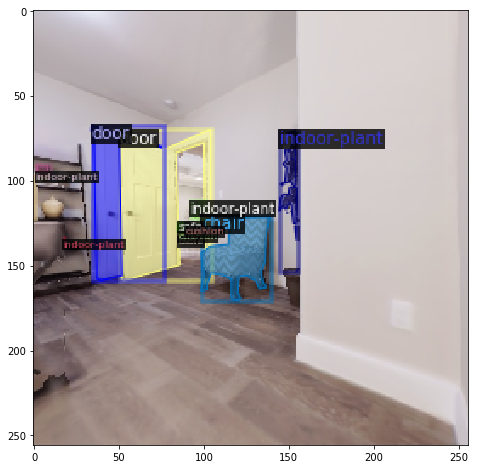

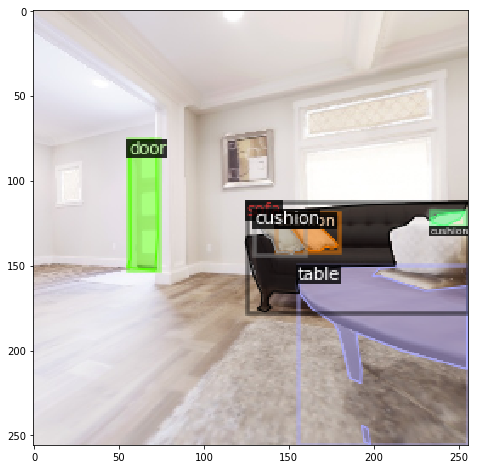

output/straightline_apt0_gt100p1_corln
[06/14 13:10:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/14 13:10:27 d2.engine.train_loop]: Starting training from iteration 0


/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:348: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:348: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of th

[06/14 13:10:32 d2.utils.events]:  eta: 0:01:23  iter: 19  total_loss: 3.665  loss_cls: 1.733  loss_box_reg: 0.8462  loss_mask: 0.6922  loss_rpn_cls: 0.2433  loss_rpn_loc: 0.1462  time: 0.2219  data_time: 0.0103  lr: 9.9905e-05  max_mem: 1859M
[06/14 13:10:36 d2.utils.events]:  eta: 0:01:21  iter: 39  total_loss: 2.697  loss_cls: 0.8809  loss_box_reg: 0.8511  loss_mask: 0.6666  loss_rpn_cls: 0.09989  loss_rpn_loc: 0.1916  time: 0.2254  data_time: 0.0039  lr: 0.0001998  max_mem: 1859M


In [ ]:
for x in train_jsons:
    c = COCOTrain()
    c.run(x, test_json, img_dir_train, img_dir_test)